# GATE: Sinogram, Random+Scatter Estimation

In [1]:
from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta, PETLMProjMeta, PETTOFMeta, PETSinogramPolygonProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix, PETSinogramSystemMatrix
from pytomography.algorithms import OSEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pytomography.io.PET import sss
from pytomography.io.PET.shared import sinogram_coordinates, sinogram_to_spatial

Required data:

In [2]:
path = '/disk1/pet_mri_scan/'
macro_path = os.path.join(path, 'mMR_Geometry.mac') 
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
scanner_LUT = gate.get_scanner_LUT(info)
# Get detector IDs from GATE file
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 19)]
macro_path = os.path.join(path, 'mMR_Geometry.mac')

Before we delve into scatter/random modeling, lets get a baseline reconstruction that uses only primary events from the simulated GATE data. We can use PyTomography functionality to select for such events when we open the ROOT data. Obviously this is not doable for clinical data (where we don't know which events are randoms/scatters).

In [3]:
detector_ids = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    include_randoms=False,
    include_scatters=False)

Lets also get the true scatters and randoms from this data so we can compare our estimation:

In [4]:
detector_ids_randoms_true = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    randoms_only=True)
detector_ids_scatters_true = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    scatters_only=True)

Now we can reconstruct as we did in the introductory tutorials.

In [5]:
object_meta = ObjectMeta(
    dr=(2,2,2), #mm
    shape=(128,128,96) #voxels
)
norm_sinogram = torch.load(os.path.join(path, 'norm_sinogram.pt')) # assumes this has been saved from the intro tutorial
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta).to(pytomography.device)
proj_meta = PETSinogramPolygonProjMeta(info)
psf_transform = GaussianFilter(4) # 2mm gaussian blurring
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       norm_sinogram = norm_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, rest is GPU
)
sinogram = gate.listmode_to_sinogram(detector_ids, info)
likelihood = PoissonLogLikelihood(
    system_matrix,
    sinogram,
)
recon_algorithm = OSEM(likelihood)
recon_primaryonly = recon_algorithm(n_iters=2, n_subsets=24)

And plot:

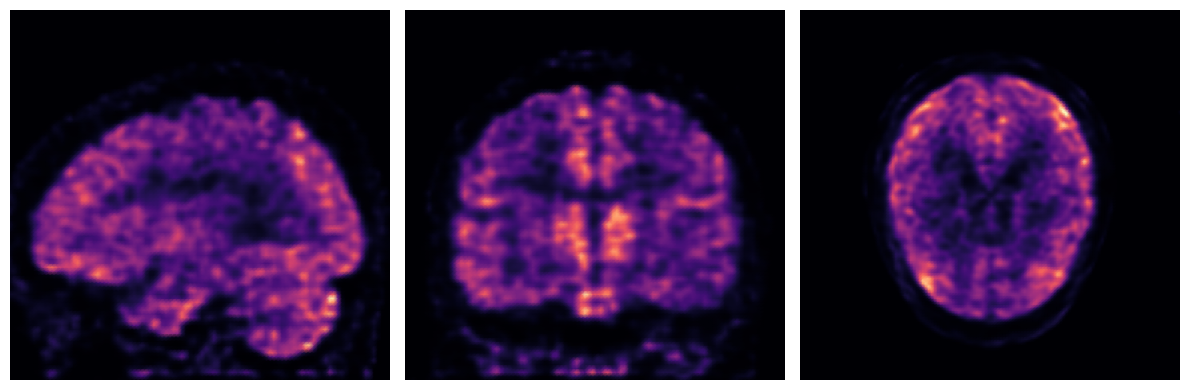

In [10]:
vmax = 0.05
fig, ax = plt.subplots(1,3,figsize=(12,4))
plt.subplot(131)
plt.pcolormesh(recon_primaryonly[0,48,16:-16].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(recon_primaryonly[0,16:-16,64].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(recon_primaryonly[0,:,:,48].cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

Note that this is not possible in clinical practice, since we don't know which events are scatters/randoms. The reconstruction above is going to be used as an "ideal" comparison for our reconstruction of all events.

## Reconstruction Correcting For Randoms + Scatters

For reconstruction of all events, we need to estimate boths randoms and scatters. Lets now get **all** events that were obtained in GATE:

In [23]:
detector_ids = gate.get_detector_ids_from_root(
    paths,
    macro_path)
sinogram = gate.listmode_to_sinogram(detector_ids, info)

### Randoms

PyTomography has functionality to estimate random events via delayed coincidences. We can obtained the delayed coincidence random events from GATE data as follows:

In [24]:
detector_ids_randoms = gate.get_detector_ids_from_root(
    paths,
    macro_path,
    substr = 'delay')

We can then convert them to sinogram format.

In [25]:
sinogram_random = gate.listmode_to_sinogram(detector_ids_randoms, info)

Let's plot the sinogram of estimated randoms ($r-z$ plane corresponding to $\theta=0$ and a ring difference of 0)

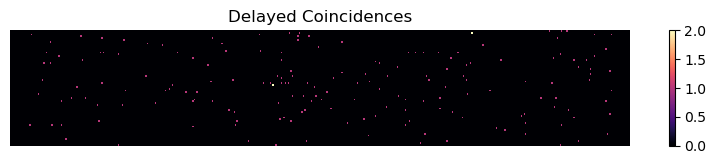

In [26]:
plt.figure(figsize=(10,1.5))
plt.pcolormesh(sinogram_random[0,:,:64].T, cmap='magma')
plt.title('Delayed Coincidences')
plt.axis('off')
plt.colorbar()

As can be seen, the data is very sparse, and is not a good estimation of randoms in all bins. In order to make this a good estimation of randoms, we can smooth the sinogram:

In [27]:
sinogram_random = gate.smooth_randoms_sinogram(sinogram_random, info, sigma_r=4, sigma_theta=4, sigma_z=4)

Let's look at the interpolated sinogram, and compare it to the real randoms:

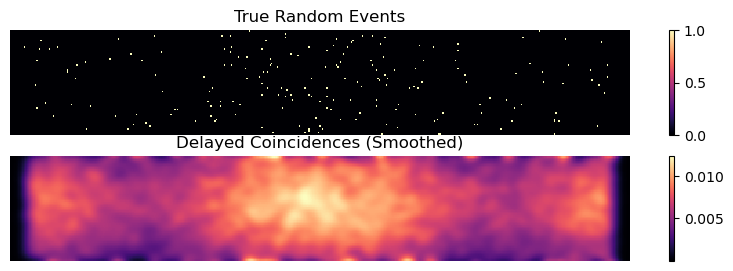

In [28]:
sinogram_randoms_true = gate.listmode_to_sinogram(detector_ids_randoms_true, info)

plt.figure(figsize=(10,3))
plt.subplot(211)
plt.pcolormesh(sinogram_randoms_true[0,:,:64].T, cmap='magma')
plt.title('True Random Events')
plt.axis('off')
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(sinogram_random[0,:,:64].T, cmap='magma')
plt.title('Delayed Coincidences (Smoothed)')
plt.axis('off')
plt.colorbar()
plt.show()

# Delete to save memory
del(sinogram_randoms_true)

Note that the delayed coincidences are intended to yield the mean random rate $\bar{r}$ in each bin; the top plot yields a particular noise realization.

### Scatters

PyTomography estimates scatters via the single scatter simulation (SSS) algorithm (w or w/o time of flight). In order to use SSS, we need an initial reconstruction of the data (without scatter estimation). We use this reconstruction as a proxy to estimate scatter. Let's first reconstruct the data without scatter estimation (but using randoms):

In [29]:
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
norm_sinogram = torch.load(os.path.join(path, 'norm_sinogram.pt')) # assumes this has been saved from the intro tutorial
proj_meta = PETSinogramPolygonProjMeta(info)
psf_transform = GaussianFilter(4)
system_matrix = PETSinogramSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       norm_sinogram = norm_sinogram,
       N_splits=10,
       attenuation_map=atten_map,
       device='cpu' # projections output on cpu, rest is GPU
)

We'll use the randoms as an additive term within the likelihood function.

* Since we don't by default include attenuation modeling/normalization correction in forward/back projection of the reconstruction algorithm (they cancel in the numerator/denominator), we need to divide the additive term by the sensitivity sinogram of the system matrix

In [30]:
additive_term = sinogram_random / system_matrix.compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )

Now we reconstruct using only random estimation

In [31]:
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(2,24)

This reconstruction is then used to estimate scatter in the SSS scatter estimation technique. The parameters are discussed below the code cell below

In [32]:
sinogram_scatter = sss.get_sss_scatter_estimate(
    object_meta = object_meta,
    proj_meta = proj_meta,
    pet_image = recon_without_scatter_estimation,
    attenuation_image = atten_map,
    system_matrix = system_matrix,
    proj_data = sinogram,
    image_stepsize = 4,
    attenuation_cutoff = 0.004,
    sinogram_interring_stepsize = 4,
    sinogram_intraring_stepsize = 4,
    sinogram_random = sinogram_random
    )

Besides the obvious parameters:

* `pet_image` is the initial activity estimation which is used to estimate the scatter contribution. Note that although the activity is much higher here than the scatter-corrected image, the scatter is not over predicted since it is scaled to the tails at the end (discussed below)
* `attenuation_image` is used to compute compton cross sections
* `system_matrix` is needed for the scaling of the scatter tails.
* `proj_data` is required for the scaling of the scatter tails.
* `image_stepsize` is the stepsize in x/y/z used for subsampling voxels in object space for the scatter simulation.
* `attenuation_cutoff` is used for two purposes: (i) any scatter point below this value is not considered and (ii) when the attenuation map is forward projected as a mask to scale the scatter tails, this is the cutoff value for the mask
* `sinogram_interring_stepsize`: the axial stepsize between detector crystals used as points in the scatter simulation
* `sinogram_intrraring_stepsize`: the transaxial stepsize between detector crystals used as points in the scatter simulation.
* `sinogram_random`: required for scaling the scatter tails at the end.

The SSS essentially works as follows: 

(i) Compute scatter estimation in sparse sinogram space (only certain detector crystals considered)
(ii) Interpolate sinogram
(iii) Scale scatter tails

Lets compare this to the true scatter distribution:



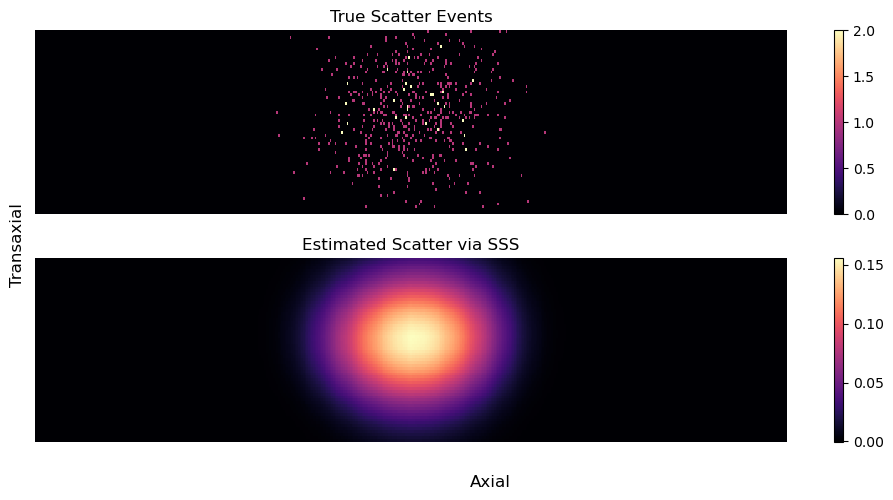

In [33]:
sinogram_scatters_true = gate.listmode_to_sinogram(detector_ids_scatters_true, info)

fig = plt.figure(figsize=(10,5))
plt.subplot(211)
plt.pcolormesh(sinogram_scatters_true[0,:,:64].T, cmap='magma')
plt.title('True Scatter Events')
plt.axis('off')
plt.colorbar()
plt.subplot(212)
plt.pcolormesh(sinogram_scatter[0,:,:64].T, cmap='magma')
plt.title('Estimated Scatter via SSS')
plt.axis('off')
plt.colorbar()
fig.supxlabel('Axial')
fig.supylabel('Transaxial')
fig.tight_layout()
plt.show()

It's a little hard to validate on the sinograms since the true scatter data is sparse. We can instead look at profiles by summing accross certain dimensions:

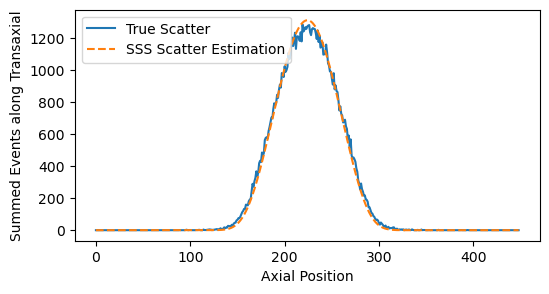

In [34]:
plt.figure(figsize=(6,3))
plt.plot(sinogram_scatters_true[:,:,:64].sum(dim=(0,2)), label='True Scatter')
plt.plot(sinogram_scatter[:,:,:64].sum(dim=(0,2)), ls='--', label='SSS Scatter Estimation')
plt.xlabel('Axial Position')
plt.ylabel('Summed Events along Transaxial')
plt.legend()
plt.show()

Now that we have the scatter sinogram estimate, we can reconstruct:

In [35]:
additive_term = (sinogram_random + sinogram_scatter) / system_matrix.compute_sensitivity_sinogram().cpu()
likelihood = PoissonLogLikelihood(
        system_matrix,
        sinogram,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_sinogram_noTOF = recon_algorithm(2,24)

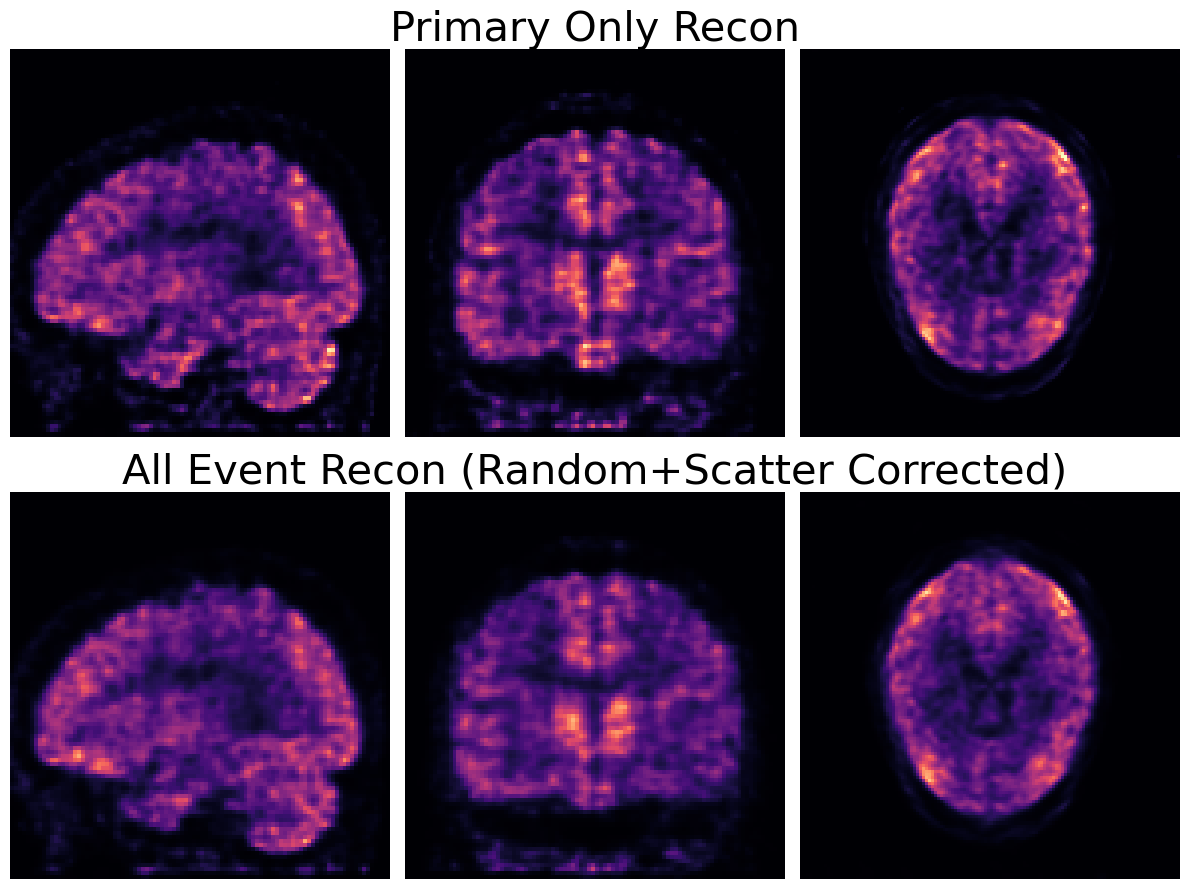

In [37]:
vmax = 0.05
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_primaryonly[0,48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_primaryonly[0,16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.title('Primary Only Recon', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_primaryonly[0,:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_sinogram_noTOF[0,48,16:-16].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_sinogram_noTOF[0,16:-16,64].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.title('All Event Recon (Random+Scatter Corrected)', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_sinogram_noTOF[0,:,:,48].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()